In [1]:
import torch as t
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual
from torch.distributions import Bernoulli
from torch.distributions import MultivariateNormal as MvNormal

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
$$

<h1> Part 1: Likelihoods and modelling </h1>

First things first:
<ul>
  <li> I'm experimenting with doing the lectures in Jupyter Notebooks.</li>
  <li> Hopefully, it means we can connect theory and code more closely.</li>
  <li> As much as possible, I'll try to prepare the ground for later deep-leaning and machine learning courses.</li>
  <li> I'm going to use PyTorch, mainly for the distributions library.</li>
  <li> PyTorch's syntax is almost exactly the same as Numpy.</li>
  <li> And so you can't copy code for labs/courseworks (which must be done in Numpy).</li>
</ul>

<h2> What is a model? </h2>

Model == a structured approach for making predictions about the future.

For instance, imagine Alice tosses a coin 10 times and gets:

H T H T H T H T H H

Now she tosses the coin again.  What happens?

One option is that the coin tosses are indeed fair and random, in which case next time we might get:

T H H H H T H T T T

or the coin might be biased, and we just happened to get an equal number of heads/tails.  Next time, we might get:

T H H H H T H H H H

or Alice might have clever trick (https://www.youtube.com/watch?v=A-L7KOjyDrE), so that next time she can get exactly the same thing:

H T H T H T H T H H

(or whatever else she wants).


<h2>Simple example: A biased coin flip</h2>
$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
$$
Lets assume that Alice doesn't have a trick, so the coin tosses are independent and random, but that the coin might be biased.
In that case, the coin-toss, $x$ can be said to be Bernoulli distributed, with probability $p$,

$$P(x| p) = \Bernoulli{x; p}$$

where,

$$\Bernoulli{x; p} = \begin{cases} 1-p &\text{ if } x=0 \\ p &\text{ if } x=1 \end{cases}$$

In [2]:
bern = Bernoulli(probs=0.7)
print(bern.log_prob(0.).exp())
print(bern.log_prob(1.).exp())

tensor(0.3000)
tensor(0.7000)


Note: PyTorch only provides the log_prob method, because this is much more numerically stable when doing deep-learning.  We therefore have to exponentiate to get back the probability.

Thus, given a probability, $p$, we can make a predictions about possible values of about Alice's future coin tosses:

In [3]:

def sample_bernoulli(p):
    return Bernoulli(probs=p).sample((10,)).to(dtype=t.int)
interact_manual(sample_bernoulli, p=FloatSlider(value=0.5, min=0, max=1, step=0.05));

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.05), Button(description='Run Int…

Key question: how do we find p?

<h3> Maximum likelihood fitting of a Bernoulli </h3>

Consider data:

T T T T H T T T T T T H

In [4]:
xs = t.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

The likelihood, i.e. the probability of all the data, treated as a function of the parameter, $p$, is

\begin{align}
  \P{\x| p} = \prod_\lambda \P{x_\lambda| p}
\end{align}

But these numbers rapidly shrink (and become too small for standard floating points).  Instead, we work with the log-likelihood,

\begin{align}
  \L(p) = \sum_\lambda \log \P{x_\lambda| p}
\end{align}

Importantly, the log-likelihood is considered a function of the parameter(s), $p$, but not the data, which is considered fixed.

The goal is to find $\ph$ which maximizes $\L(p)$,

\begin{align}
  \ph = \argmax_{p} \L(p)
\end{align}

Lets find $ \ph $!  We can code-up the log-likelihood using,

In [5]:
def log_likelihood(p):
    return Bernoulli(probs=p).log_prob(xs).sum(-1, keepdim=True)

interact(log_likelihood, p=FloatSlider(min=0.01, max=0.99, step=0.01));

interactive(children=(FloatSlider(value=0.01, description='p', max=0.99, min=0.01, step=0.01), Output()), _dom…

Lets plot the log-likelihood,

In [6]:
ps = t.linspace(0.01, 0.99, 99)[:, None]
print(ps.shape)
ps[:6, :]

torch.Size([99, 1])


tensor([[0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600]])

In [7]:
lls = log_likelihood(ps)
lls.shape

torch.Size([99, 1])

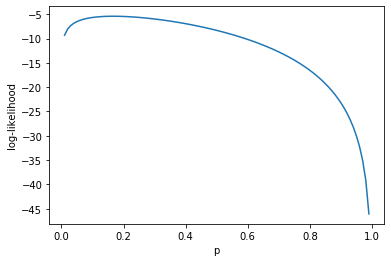

In [8]:
fig, ax = plt.subplots()
ax.plot(ps, lls)
ax.set_xlabel("p")
ax.set_ylabel("log-likelihood");

In simple cases like this, we could just use the above plot to find the value of $ p $ with the maximal log-likelihood.

But in more complicated cases with many more parameters, this is no longer possible.

Instead, the first approach is to try to find an analytic expression for the $p$ with the maximal log-probability.

Remember,

\begin{align}
  \L(p) &= \sum_\lambda \log \P{x_\lambda| p}\\
  \L(p) &= \b{\sum_\lambda x_\lambda} \log p + \b{N - \sum_\lambda x_\lambda} \log (1-p)
\end{align}

And solve for where the gradient is zero,

\begin{align}
  0 &= \at{\dd[\L(p)]{p}}_{p=\ph}\\
  0 &= \frac{\sum_\lambda x_\lambda}{\ph} - \frac{N - \sum_\lambda x_\lambda}{1-\ph}\\
  \frac{\sum_\lambda x_\lambda}{\ph} &= \frac{N - \sum_\lambda x_\lambda}{1-\ph}\\
  (1-\ph) \sum_\lambda x_\lambda &= \ph \b{N - \sum_\lambda x_\lambda}\\
  \sum_\lambda x_\lambda &= \ph N\\
  \ph &= \tfrac{1}{N} \sum_i x_i
\end{align}

The maximum-likelihood probability is the empirical mean of the data points.  This is sensible, but not at all obvious: we needed to go through the derivation!

Using this derivation, we can write a function that automatically fits a Bernoulli distribution,

In [9]:
def fit_bernoulli(xs):
    p = xs.sum() / xs.shape[-1]
    return Bernoulli(probs=p)

fitted_bernoulli = fit_bernoulli(xs)
fitted_bernoulli

Bernoulli(probs: 0.1666666716337204)

such that samples from the fitted Bernoulli look like the data,

In [10]:
xs

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

In [11]:
fitted_bernoulli.sample((12,))

tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

<h3> Bayesian fitting of a Bernoulli </h3>

Maximum likelihood works well when we have a reasonable number of datapoints.

But what about when we have very little data (e.g. we might have many biased coins, and be able to toss each one a few times).

In particular, lets say we have a population of coins, whose probabilities are drawn from a uniform distribution,

\begin{align}
  \P{p} &= \text{Uniform}(p; 0, 1)
\end{align}

we take out one coin, toss it twice, and get two zeros,

In [12]:
xs = t.tensor([0., 0.])

What can we say about $p$?

Maximum likelihood would tell us that $ \ph = 0 $,

In [13]:
fit_bernoulli(xs)

Bernoulli(probs: 0.0)

Which is a bit strange, because $ p $ could have been quite large, but coincidentally, our two coin-tosses happened to be zeros.

To understand this in a bit more depth, we can run a simulation.

We start by drawing a large number of $ p $'s, from the uniform prior,

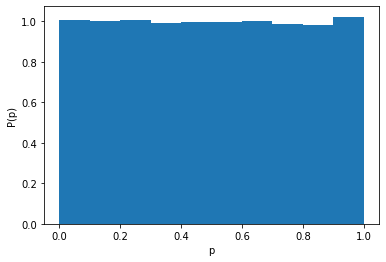

In [14]:
N = 10**5
ps = t.rand(N)
fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("P(p)")
ax.hist(ps, density=True);

Note: the values on the x-axis are probability *densities*, not probabilities.

The probability of being in any given bin is:
\begin{align}
  \int_{p_0}^{p_0 + \delta} dp \; \P{p} \approx \delta \P{p}
\end{align}
i.e. the bin-width times the probability density.

Here, we have $10$ bins, with probability density $1$, and bin width $\delta = 1/20$.

The probability of being in any 1 bin is therefore $\P{p} \times \delta = 1 \times 1/10 = 1/10$, and adding up the $10$ bins gives us $1$.

Then, for each of these $ p $'s, we toss a couple of coins,

In [15]:
xs = Bernoulli(ps).sample((2,))
xs
xs.shape

torch.Size([2, 100000])

Then, we filter out only those values of $ p $ which actually gave us two zeros,

In [16]:
all_zeros = (xs==0.).all(0)
print(all_zeros)
print(all_zeros.sum())
ps_all_zeros = ps[all_zeros]
print(ps_all_zeros.shape)

tensor([False,  True, False,  ...,  True, False,  True])
tensor(33303)
torch.Size([33303])


Now, we can plot those $ p $'s

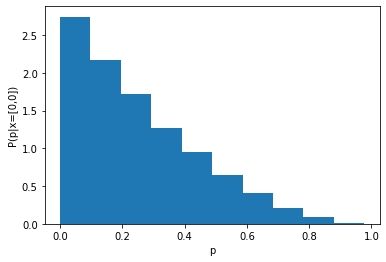

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("P(p|x=[0,0])")
ax.hist(ps_all_zeros, density=True);

This makes sense: we expect the probability to be small, because when we flipped the coin, we observed two zeros.

But the probability could still be large, with the two zeros we observed being coincidences.

It turns out this idea (sampling until we get something very close to the data, then looking at the corresponding latents, here the probability, $p$), is a real algorithm, called "approximate Bayesian computation" (ABC).

But its a terrible idea: don't do it in practice unless you really have to.  For any non-trivial dataset, you will be waiting a very, very long time before random sampling produces something "sufficient close".

Instead, can we do exact Bayesian inference to directly compute the distribution $\P{p| \x}$.

The answer is yes!

In particular, the law of joint probability tells us that we can write the joint, $\P{\x, p}$ in two equivalent forms,

\begin{align}
  \P{\x, p} &= \P{\x| p} \P{p} = \P{p| \x} \P{\x}
\end{align}

The first form $\P{\x| p} \P{p}$, is the standard one, and we can readily compute it given the expressions above.  The second form, $\P{p| \x} \P{\x}$ is a bit more unusual: it isn't immediately obvious how we can compute these terms.

Nonetheless, we can rearrange to compute the term we're interested in,

\begin{align}
  \P{p| \x} &= \frac{\P{\x| p} \P{p}}{\P{\x}} \propto \P{\x| p} \P{p}\\
  \log \P{p| \x} &= \L\b{p} + \log \P{p} + \text{const}
\end{align}

The proportionality arises because we take data, $\x$, to be fixed, so we only care about parameter, $p$ dependence (as long as we make sure the distribution normalizes!

Lets do it!

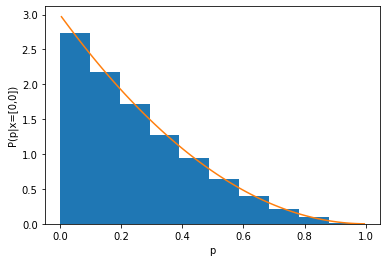

In [18]:
xs = t.Tensor([0., 0.])

def log_prior(p):
    return 0.

def log_likelihood(p):
    return Bernoulli(p).log_prob(xs).sum(-1, keepdim=True)

ps = t.linspace(0.005, 0.995, 100).view(-1, 1)
dp = ps[1] - ps[0]
    
unnorm_log_posterior = log_prior(ps) + log_likelihood(ps)
unnorm_posterior = unnorm_log_posterior.exp()
norm_posterior = unnorm_posterior / (dp * unnorm_posterior.sum())

fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("P(p|x=[0,0])")
ax.hist(ps_all_zeros, density=True);
ax.plot(ps, norm_posterior);

It is possible to analytically compute the distribution over $p$ for a coin-toss.  But this doesn't give us much additional insight.  Instead, we'll do this below for a Gaussian distribution.

<h2>More interesting examples</h2>
In the previous example, a datapoint was either 0 or 1,

```
X = {0, 1}
```

but $ x $ could take on almost any other type.  Common examples include:

```
X = Vector{Float}   # A vector
X = Str             # A string
X = Image           # An image
```

Complex, state-of-the-art models for images (GANs) and text (GTP-2) do exactly what we described above.
Then, they take a large dataset of images/text do a very large amount of processing, to fit a distribution to that data.
Once the distribution has been fitted, they can draw samples from that distribution, that should look like the data.

<h2> Multivariate Normal (Gaussian)</h2>
The multivariate Normal is the most important distribution over vectors.

\begin{align}
  \P{\x| \m, \S} &= \N{\x; \m, \S}\\
  \log \N{\x; \m, \S} &= -\tfrac{1}{2} \log \det{2 \pi \S} - \tfrac{1}{2} \b{\x - \m} \S^{-1} \b{\x-\m}^T
\end{align}

The expectation of the distribution is given by $\m$ and the covariance is given by $\S$,

\begin{align}
  \E{\x} &= \m\\
  \Cov{\x} &= \S
\end{align}

To get some intuition for what the covariance means, we can plot samples from a multivariate normal with the same variance for $x_0$ and $x_1$, but different covariances,

In [19]:
def plot(c):
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    
    mu = t.zeros(2)
    Sigma = c*t.ones(2, 2) + (1-c)*t.eye(2)
    print("Sigma =")
    print(Sigma)
    dist = MvNormal(mu, Sigma)
    xs = dist.sample((10000,))
    ax.scatter(xs[:, 0], xs[:, 1])
    
interact_manual(plot, c=FloatSlider(value=0, min=-0.99, max=0.99, step=0.01));

interactive(children=(FloatSlider(value=0.0, description='c', max=0.99, min=-0.99, step=0.01), Button(descript…

To begin, consider positive $\Cov{x_0, x_1} = \E{x_0 x_1}$.  To get positive covariances, $x_0$ and $x_1$ will tend to have the same sign (either both positive or both negative), so the overall product, $x_0 x_1$ is usually positive.

Now, consider negative $\Cov{x_0, x_1} = \E{x_0 x_1}$.  To get negative covariances, $x_0$ and $x_1$ will tend to have the different signs (one positive and the other negative), so the overall product, $x_0 x_1$ is usually negative.

Now, consider $0 = \Cov{x_0, x_1} = \E{x_0 x_1}$.  In this case, $x_0$ and $x_1$ are unrelated.

As the covariance approaches the variance, the distribution gets narrower.

Until eventually, the only way of achieving,

\begin{align}
  1 = \Var{x_0} = \Var{x_1} \approx \Cov{x_0, x_1} = \E{x_0 x_1}
\end{align}

is by setting,

\begin{align}
  x_0 = x_1
\end{align}

<h3>Maximum likelihood fitting</h3>

Maximum likelihood parameters, $\m$ and $\S$, for a multivariate normal is given by the empirical mean, $\mh$ and covariance $\Sh$,

\begin{align}
  \mh, \Sh = \argmax_{\m, \S} \sb{\sum_\lambda \log \N{\x_\lambda| \m, \S}}
\end{align}

This seems sensible, but requires some fairly hairy matrix differentials to prove.